# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import compute_likelihood
import lya_theory

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_04052019/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.1'
emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

In [3]:
# let's keep verbosity low
emu.verbose=False
emu.arxiv.verbose=False

### Read P1D data from Palanque-Delabrouille et al. (2013)

In [4]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=False)
zs=data.z
Nz=len(zs)

### Setup nuisance models

In [5]:
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel(ln_gamma_coeff=[np.log(1.4)])

In [6]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.542428
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.400000


### Setup cosmological model

Can run the code starting from an actual cosmological model (from CAMB) or from a set of linP parameters

In [7]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
use_linP_params=True
if use_linP_params:
    linP_params={'f_star': 0.97664687870657374, 'g_star': 0.9709060615373754,
                 'Delta2_star': 0.35998124879741872, 'n_star': -2.3003810483122491,
                 'alpha_star': -0.2160018587455611}
    linP_model=fit_linP.LinearPowerModel(params=linP_params,z_star=z_star,k_units='kms',kp=kp_kms)
else:
    # specify cosmology
    cosmo = camb_cosmo.get_cosmology(mnu=0.15,As=2.2e-9,H0=65.0)
    # print relevant information about the cosmology object
    camb_cosmo.print_info(cosmo)
    # parameterize cosmology
    linP_model=fit_linP.LinearPowerModel(cosmo=cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
    linP_params=linP_model.get_params()
    print('linP_params',linP_params)

### Setup Lyman alpha theory

In [8]:
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)

Note: redshifts have been re-sorted (earliest first)


In [9]:
theory.set_cosmo_model(linP_model)
theory.set_mf_model(mf_model)
theory.set_T_model(T_model)

In [10]:
# emulate P1D for all redshifts
k_kms=data.k
emu_p1d_kms=theory.get_p1d_kms(k_kms)

### For each redshift, plot data vs model

(0.005, 0.6)

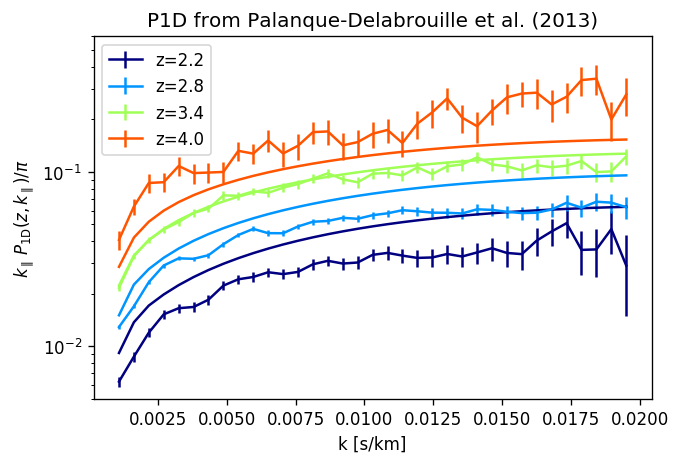

In [11]:
# plot only few redshifts for clarity
for iz in range(0,Nz,3):
    # acess data for this redshift
    z=zs[iz]
    k_kms=data.k
    p1d=data.get_Pk_iz(iz)
    cov=data.get_cov_iz(iz)
    emu_p1d = emu_p1d_kms[iz]
    # plot everything
    col = plt.cm.jet(iz/(Nz-1))
    plt.errorbar(k_kms,p1d*k_kms/np.pi,color=col,yerr=np.sqrt(np.diag(cov))*k_kms/np.pi,label='z=%.1f'%z)
    plt.plot(k_kms,emu_p1d*k_kms/np.pi,color=col)
plt.yscale('log')
plt.legend()
plt.title('P1D from Palanque-Delabrouille et al. (2013)')
plt.xlabel('k [s/km]')
plt.ylabel(r'$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$')
plt.ylim(0.005,0.6)

In [12]:
chi2 = compute_likelihood.get_chi2(data,theory,verbose=True)

got P1D from emulator
compute chi2 for z=2.2
added 791.3083375294731 to chi2
compute chi2 for z=2.4
added 762.2051243616683 to chi2
compute chi2 for z=2.6
added 211.0250381027115 to chi2
compute chi2 for z=2.8
added 1430.4972667333361 to chi2
compute chi2 for z=3.0
added 2527.9523752991654 to chi2
compute chi2 for z=3.2
added 2094.086412442336 to chi2
compute chi2 for z=3.4
added 407.4742335592314 to chi2
compute chi2 for z=3.6
added 168.6040707954857 to chi2
compute chi2 for z=3.8
added 311.7092048380259 to chi2
compute chi2 for z=4.0
added 1701.3531628667686 to chi2
compute chi2 for z=4.2
added 1296.8172750025578 to chi2
compute chi2 for z=4.4
added 3030.7887500140523 to chi2


In [13]:
chi2

14733.82125154481

### Plot chi2 vs mean optical depth parameter

In [14]:
# effective optical depth at z=3
tau_0 = np.linspace(0.3,0.55,50)
Ntau=len(tau_0)

In [15]:
chi2_tau=np.empty(Ntau)
for i in range(Ntau):
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.2, np.log(tau_0[i])])
    mf_model.get_mean_flux(z=3.0)
    theory.set_mf_model(mf_model)
    chi2_tau[i] =compute_likelihood.get_chi2(data,theory,verbose=False)
    #print(i,tau_0[i],np.exp(-tau_0[i]),'chi2 =',chi2_tau[i])

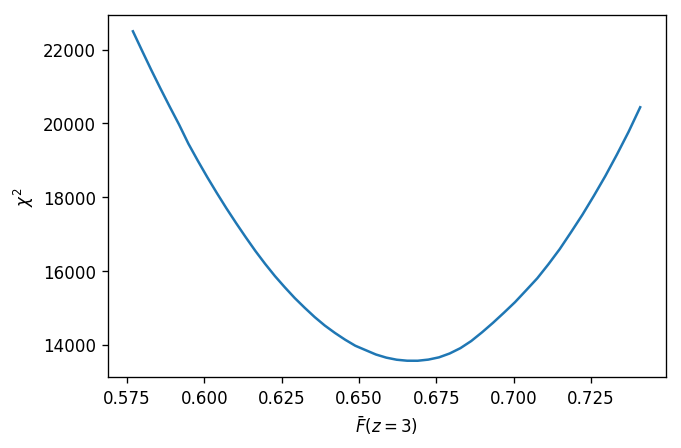

In [16]:
plt.plot(np.exp(-tau_0),chi2_tau)
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')